In [2]:
import torch
from tqdm import tqdm
import os
from pytorch_adapt.containers import Models, Optimizers
from pytorch_adapt.datasets import DataloaderCreator, get_mnist_mnistm, get_office31
from pytorch_adapt.datasets.office31 import Office31
from pytorch_adapt.hooks import DANNHook
from pytorch_adapt.adapters import DANN

from pytorch_adapt.models import Discriminator, mnistC, mnistG, office31C, office31G
from pytorch_adapt.utils.common_functions import batch_to_device
from pytorch_adapt.validators import IMValidator, AccuracyValidator

from pprint import pprint


In [18]:
root="datasets/pytorch-adapt/"
batch_size=32
num_workers=2

datasets = get_office31(["amazon"], ["webcam"], folder=root, return_target_with_labels=True)
dc = DataloaderCreator(batch_size=batch_size, 
                        num_workers=num_workers, 
                        train_names=["train"],
                        val_names=["src_train", "target_train", "src_val", "target_val", "target_train_with_labels", "target_val_with_labels"])
dataloaders = dc(**datasets)

In [3]:
print(dataloaders.keys())
# 'train' dataset type is `CombinedSourceAndTargetDataset` and contains both source and unlabeled target data
# 'src_train' and 'src_val' datasets types are `SourceDataset`
# Other datasets are typed `TargetDataset`

dict_keys(['src_train', 'src_val', 'target_train', 'target_val', 'target_train_with_labels', 'target_val_with_labels', 'train'])


In [4]:
for k in dataloaders.keys():
    print(k, len(dataloaders[k]), len(dataloaders[k].dataset))
    for a in dataloaders[k]:
        print(a.keys())
        break

src_train 71 2253
dict_keys(['src_imgs', 'src_domain', 'src_labels', 'src_sample_idx'])
src_val 18 564
dict_keys(['src_imgs', 'src_domain', 'src_labels', 'src_sample_idx'])
target_train 20 636
dict_keys(['target_imgs', 'target_domain', 'target_sample_idx'])
target_val 5 159
dict_keys(['target_imgs', 'target_domain', 'target_sample_idx'])
target_train_with_labels 20 636
dict_keys(['target_imgs', 'target_domain', 'target_sample_idx', 'target_labels'])
target_val_with_labels 5 159
dict_keys(['target_imgs', 'target_domain', 'target_sample_idx', 'target_labels'])
train 19 636
dict_keys(['src_imgs', 'src_domain', 'src_labels', 'src_sample_idx', 'target_imgs', 'target_domain', 'target_sample_idx'])


In [3]:

device = torch.device("cuda")
weights_root = os.path.join(root, "weights")
trained_domain = "amazon"

G = office31G(pretrained=True, model_dir=weights_root).to(device)
C = office31C(domain=trained_domain, pretrained=True, model_dir=weights_root).to(device)
D = Discriminator(in_size=2048, h=256).to(device)
models = Models({"G": G, "C": C, "D": D})
optimizers = Optimizers((torch.optim.Adam, {"lr": 0.001}))
optimizers.create_with(models)
optimizers = list(optimizers.values())

hook = DANNHook(optimizers)

from pytorch_adapt.validators import AccuracyValidator, BaseValidator
from pytorch_adapt.layers import BNMLoss

class CustomTargetValidator(BaseValidator):
    def compute_score(self, target_train):
        return BNMLoss()(target_train["preds"])

src_train_validator = AccuracyValidator(key_map={"src_train": "src_val"})
src_val_validator = AccuracyValidator(key_map={"src_val": "src_val"})
target_validator = CustomTargetValidator()
target_train_oracle_validator = AccuracyValidator(key_map={"target_train": "src_val"})
target_val_oracle_validator = AccuracyValidator(key_map={"target_val": "src_val"})
targen_im_validator = IMValidator()


In [4]:
torch.cuda.empty_cache()


from tqdm import tqdm
from pytorch_adapt.utils.common_functions import batch_to_device
from collections import defaultdict


def get_preds_and_labels(split, full_key):
    output = defaultdict(list)
    with torch.no_grad():
        for data in tqdm(dataloaders[full_key]):
            data = batch_to_device(data, device)
            logits = C(G(data[f"{split}_imgs"]))
            output["logits"].append(logits)
            curr_preds = torch.softmax(logits, dim=1)
            output["preds"].append(curr_preds)
            if full_key in ["src_train", "src_val", "target_train_with_labels", "target_val_with_labels"]:
                output["labels"].append(data[f"{split}_labels"])
    for k,v in output.items():
        output[k] = torch.cat(v, dim=0)
    return output
    
for epoch in range(100):
    # train loop
    models.train()
    for data in tqdm(dataloaders["train"]):
        data = batch_to_device(data, device)
        _, loss = hook({**models, **data})
    pprint(loss)

    # eval loop
    scores = []
    # src_outputs = get_preds_and_labels("src", "src_train")
    # score = src_train_validator(src_train=src_outputs)
    # scores.append(f"src_train accuracy \t= {score}")

    src_outputs = get_preds_and_labels("src", "src_val")
    score = src_val_validator(src_val=src_outputs)
    scores.append(f"src_val accuracy \t= {score}")

    # target_outputs = get_preds_and_labels("target", "target_train_with_labels")
    # score = target_train_oracle_validator(target_train=target_outputs)
    # scores.append(f"target_train accuracy \t= {score}")

    target_outputs = get_preds_and_labels("target", "target_val_with_labels")
    score = target_val_oracle_validator(target_val=target_outputs)
    scores.append(f"target_train accuracy \t= {score}")

    target_outputs = get_preds_and_labels("target", "target_train")
    score = targen_im_validator(target_train={"logits": target_outputs['logits']})
    scores.append(f"target_train score (IM)\t= {score}")

    # score = target_validator(target_train=target_outputs)
    # scores.append(f"target_train score (BNM) \t= {score}")

    print(f"Target Evaluation:")
    print(*scores, sep="\n")

100%|██████████| 19/19 [00:49<00:00,  2.63s/it]


{'total_loss': {'src_c_loss': 3.168257236480713,
                'src_domain_loss': 0.7317013740539551,
                'target_domain_loss': 0.6301205158233643,
                'total': 1.5100263357162476}}


100%|██████████| 20/20 [00:09<00:00,  2.16it/s]


Target Evaluation:
src_val accuracy 	= 0.12411347776651382
target_train accuracy 	= 0.08805031329393387
target_train score (IM) 	= 0.4806191921234131


100%|██████████| 19/19 [00:51<00:00,  2.69s/it]


{'total_loss': {'src_c_loss': 2.804849624633789,
                'src_domain_loss': 0.6947869062423706,
                'target_domain_loss': 0.6891149282455444,
                'total': 1.3962504863739014}}


100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Target Evaluation:
src_val accuracy 	= 0.13652482628822327
target_train accuracy 	= 0.16352201998233795
target_train score (IM) 	= 0.6105575561523438


100%|██████████| 19/19 [00:51<00:00,  2.71s/it]


{'total_loss': {'src_c_loss': 3.0151782035827637,
                'src_domain_loss': 0.7150613069534302,
                'target_domain_loss': 0.8466196060180664,
                'total': 1.5256197452545166}}


100%|██████████| 20/20 [00:09<00:00,  2.14it/s]


Target Evaluation:
src_val accuracy 	= 0.14007091522216797
target_train accuracy 	= 0.1949685513973236
target_train score (IM) 	= 1.0187971591949463


100%|██████████| 19/19 [00:52<00:00,  2.75s/it]


{'total_loss': {'src_c_loss': 2.8740577697753906,
                'src_domain_loss': 0.6584925651550293,
                'target_domain_loss': 0.7099870443344116,
                'total': 1.4141792058944702}}


100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Target Evaluation:
src_val accuracy 	= 0.13297872245311737
target_train accuracy 	= 0.23270440101623535
target_train score (IM) 	= 0.8761472702026367


 89%|████████▉ | 17/19 [00:48<00:05,  2.82s/it]


KeyboardInterrupt: 

: 

In [ ]:
torch.cuda.empty_cache()

----

## Dataset Visualization

['amazon']


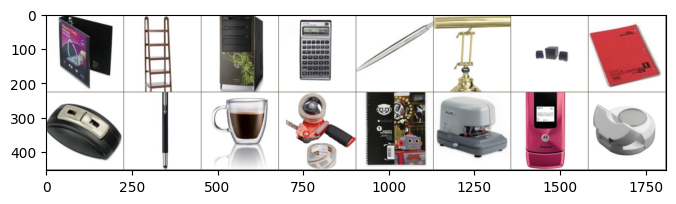

['dslr']


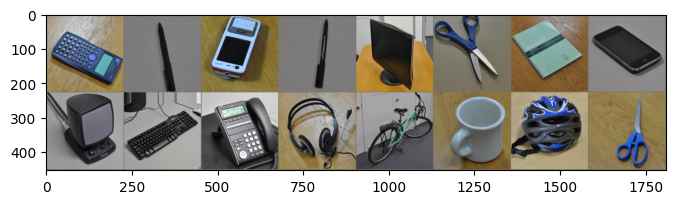

['webcam']


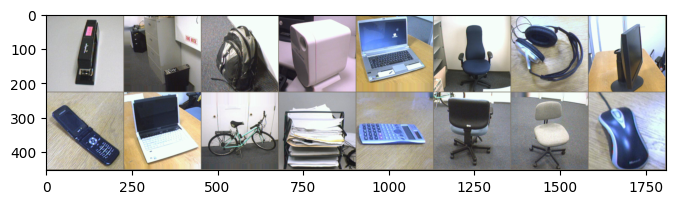

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inv_normalize = torchvision.transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)], std=[1 / s for s in std]
)

def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imshow_many(datasets, src, target):
    d = datasets["train"]
    for name in ["src_imgs", "target_imgs"]:
        domains = src if name == "src_imgs" else target
        if len(domains) == 0:
            continue
        print(domains)
        imgs = [d[i][name] for i in np.random.choice(len(d), size=16, replace=False)]
        imshow(torchvision.utils.make_grid(imgs))

for src, target in [(["amazon"], ["dslr"]), (["webcam"], [])]:
    datasets = get_office31(src, target,folder=root)
    imshow_many(datasets, src, target)

---

## Ignite

In [4]:
import logging

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import umap
from tqdm import tqdm
import os

from pytorch_adapt.adapters import DANN, MCD
from pytorch_adapt.containers import Models, Optimizers, LRSchedulers
from pytorch_adapt.datasets import DataloaderCreator, get_mnist_mnistm, get_office31
from pytorch_adapt.frameworks.ignite import CheckpointFnCreator, Ignite
from pytorch_adapt.models import Discriminator, mnistC, mnistG, office31C, office31G
from pytorch_adapt.validators import AccuracyValidator, IMValidator, ScoreHistory

from pprint import pprint


logging.basicConfig()
logging.getLogger("pytorch-adapt").setLevel(logging.INFO)

In [5]:
class VizHook:
    def __init__(self):
        self.required_data = ["src_val", "target_val", "target_val_with_labels"]

    def __call__(self, epoch, src_val, target_val, target_val_with_labels, **kwargs):

        accuracy_validator = AccuracyValidator()
        accuracy = accuracy_validator.compute_score(src_val=src_val)
        print("src_val accuracy:", accuracy)
        accuracy_validator = AccuracyValidator()
        accuracy = accuracy_validator.compute_score(src_val=target_val_with_labels)
        print("target_val accuracy:", accuracy)

        if epoch % 1 != 0:
            return

        features = [src_val["features"], target_val["features"]]
        domain = [src_val["domain"], target_val["domain"]]
        features = torch.cat(features, dim=0).cpu().numpy()
        domain = torch.cat(domain, dim=0).cpu().numpy()
        emb = umap.UMAP().fit_transform(features)

        df = pd.DataFrame(emb).assign(domain=domain)
        df["domain"] = df["domain"].replace({0: "Source", 1: "Target"})
        sns.set_theme(style="white", rc={"figure.figsize": (6, 4)})
        sns.scatterplot(data=df, x=0, y=1, hue="domain", s=15)
        plt.savefig(f"results/vishook/dann/val_{epoch}.png") 
        plt.show()
        plt.close('all')

In [6]:
root="datasets/pytorch-adapt/"
batch_size=32
num_workers=2

datasets = get_office31(["amazon"], ["webcam"], folder=root, return_target_with_labels=True)
dc = DataloaderCreator(batch_size=batch_size, 
                        num_workers=num_workers, 
                        train_names=["train"],
                        val_names=["src_train", "target_train", "src_val", "target_val", "target_train_with_labels", "target_val_with_labels"])
dataloaders = dc(**datasets)

In [4]:
device = torch.device("cuda")
weights_root = os.path.join(root, "weights")
trained_domain = "amazon"

G = office31G(pretrained=True, model_dir=weights_root).to(device)
C = office31C(domain=trained_domain, pretrained=True, model_dir=weights_root).to(device)
D = Discriminator(in_size=2048, h=1024).to(device)

models = Models({"G": G, "C": C, "D": D})

optimizers = Optimizers((torch.optim.Adam, {"lr": 0.0005}))
lr_schedulers = LRSchedulers((torch.optim.lr_scheduler.ExponentialLR, {"gamma": 0.99}))

adapter = DANN(models=models, optimizers=optimizers, lr_schedulers=lr_schedulers)
checkpoint_fn = CheckpointFnCreator(dirname="saved_models", require_empty=False)
validator = ScoreHistory(IMValidator())
tarAccuracyValidator = AccuracyValidator(key_map={"target_val_with_labels":"src_val"})
val_hooks = [ScoreHistory(AccuracyValidator()), ScoreHistory(tarAccuracyValidator), VizHook()]
trainer = Ignite(
    adapter, validator=validator, val_hooks=val_hooks, checkpoint_fn=checkpoint_fn
)

2021-05-21 13:49:42,518 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model
2021-05-21 13:49:42,519 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model
2021-05-21 13:49:42,520 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


In [7]:
from pytorch_adapt.layers import MultipleModels
from pytorch_adapt.utils import common_functions 
import copy

device = torch.device("cuda")
weights_root = os.path.join(root, "weights")
trained_domain = "amazon"

G = office31G(pretrained=True, model_dir=weights_root).to(device)
C0 = office31C(domain=trained_domain, pretrained=True, model_dir=weights_root).to(device)
C1 = common_functions.reinit(copy.deepcopy(C0))
C = MultipleModels(C0, C1)

models = Models({"G": G, "C": C})

optimizers = Optimizers((torch.optim.Adam, {"lr": 0.0005}))
lr_schedulers = LRSchedulers((torch.optim.lr_scheduler.ExponentialLR, {"gamma": 0.99}))

adapter= MCD(models=models, optimizers=optimizers, lr_schedulers=lr_schedulers)
# adapter = DANN(models=models, optimizers=optimizers, lr_schedulers=lr_schedulers)
checkpoint_fn = CheckpointFnCreator(dirname="saved_models", require_empty=False)
validator = ScoreHistory(IMValidator())
tarAccuracyValidator = AccuracyValidator(key_map={"target_val_with_labels":"src_val"})
val_hooks = [ScoreHistory(AccuracyValidator()), ScoreHistory(tarAccuracyValidator), VizHook()]
trainer = Ignite(
    adapter, validator=validator, val_hooks=val_hooks, checkpoint_fn=checkpoint_fn
)

2021-05-21 14:16:07,148 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model
2021-05-21 14:16:07,152 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


In [8]:
logging.getLogger("pytorch-adapt").setLevel(logging.WARNING)

early_stopper_kwargs = {"patience":2}


best_score, best_epoch = trainer.run(
    datasets, dataloader_creator=dc, max_epochs=5, check_initial_score=True, early_stopper_kwargs=early_stopper_kwargs
)
print(f"best_score={best_score}, best_epoch={best_epoch}")

RuntimeError: CUDA error: out of memory

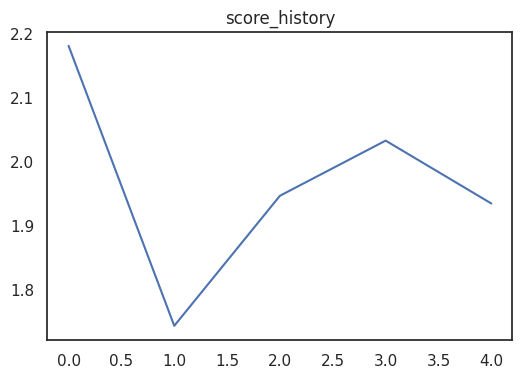

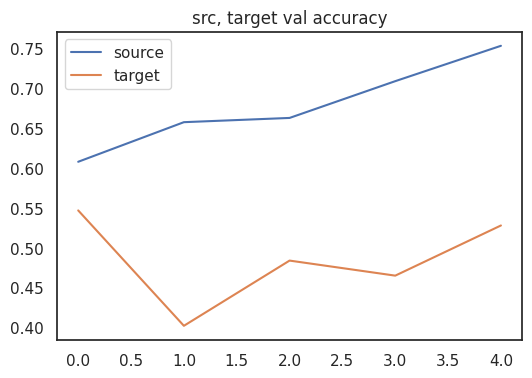

: 

In [10]:
plt.plot(validator.score_history[1:])
plt.title("score_history")
plt.show()

plt.plot(val_hooks[0].score_history[1:], label='source')
plt.plot(val_hooks[1].score_history[1:], label='target')
plt.legend()
plt.title("src, target val accuracy")
plt.show()

validator score history [2.85106766 1.07307923 1.06300926 1.43146741 1.88468337 1.96975768
 2.14979064 2.62666798 2.61236888 2.4836719  2.59688711 2.05844843
 2.02083945 2.18156433 2.30989116 2.43664771 2.50495136 2.57028472
 2.55985087 2.59315497 2.65624613]
src_val accuracy history [0.90425533 0.20921986 0.40602836 0.52482271 0.49822694 0.5673759
 0.57624114 0.59042555 0.59751773 0.57978725 0.63297874 0.57446808
 0.65602839 0.66312057 0.66489363 0.66666669 0.65957445 0.65957445
 0.67730498 0.67375886 0.66666669]


In [7]:
validator = AccuracyValidator(key_map={"target_val_with_labels": "src_val"})
score = trainer.evaluate_best_model(datasets, validator, dc)
print(score)

INFO:pytorch-adapt:***EVALUATING BEST MODEL***
INFO:pytorch-adapt:Collecting target_val_with_labels
INFO:pytorch-adapt:Setting models to eval() mode


[1/5]  20%|##        |it [00:00<?]

0.48427674174308777


In [8]:
validator = AccuracyValidator(key_map={"src_val": "src_val"})
score = trainer.evaluate_best_model(datasets, validator, dc)
print(score)

INFO:pytorch-adapt:***EVALUATING BEST MODEL***
INFO:pytorch-adapt:Collecting src_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/18]   6%|5         |it [00:00<?]

0.6666666865348816


### LOAD

In [6]:
path = "/media/10TB71/shashemi/Domain-Adaptation/results/DAModels.CORAL/0/w2d/saved_models/checkpointer_49.pt"
base_path = "/media/10TB71/shashemi/Domain-Adaptation/results/DAModels.CORAL/0/w2d/saved_models/"
checkpoint = torch.load(path)

In [22]:
base_path = "/media/10TB71/shashemi/Domain-Adaptation/results/DAModels.DANN/0/w2a/saved_models/"

In [23]:

import matplotlib.pyplot as plt
import torch
import os
import gc
from datetime import datetime

from pytorch_adapt.datasets import DataloaderCreator, get_office31
from pytorch_adapt.frameworks.ignite import CheckpointFnCreator, Ignite
from pytorch_adapt.validators import AccuracyValidator, IMValidator, ScoreHistory, DiversityValidator, EntropyValidator, MultipleValidators

from models import get_model
from utils import DAModels

from pytorch_adapt.frameworks.ignite import (
    CheckpointFnCreator,
    IgniteValHookWrapper,
    checkpoint_utils,
)

checkpoint_fn = CheckpointFnCreator(dirname=base_path, require_empty=False, n_saved=None)
    
    
sourceAccuracyValidator = AccuracyValidator()
validators = {
    "entropy": EntropyValidator(),
    "diversity": DiversityValidator(),
    # "accuracy": sourceAccuracyValidator,
}
validator = ScoreHistory(MultipleValidators(validators))


targetAccuracyValidator = AccuracyValidator(key_map={"target_val_with_labels": "src_val"})


val_hooks = [ScoreHistory(sourceAccuracyValidator), 
            ScoreHistory(targetAccuracyValidator)]

source_domain ="webcam"
target_domain = "amazon"

G = office31G(pretrained=True, model_dir=weights_root).to(device)
C = office31C(domain=source_domain, pretrained=True,
                model_dir=weights_root).to(device)
D = Discriminator(in_size=2048, h=1024).to(device)

optimizers = Optimizers((torch.optim.Adam, {"lr": 1e-4}))
lr_schedulers = LRSchedulers((torch.optim.lr_scheduler.ExponentialLR, {"gamma": 0.99}))


models = Models({"G": G, "C": C, "D": D})
adapter = DANN(models=models, optimizers=optimizers, lr_schedulers=lr_schedulers)


trainer = Ignite(
    adapter, validator=validator, val_hooks=val_hooks, checkpoint_fn=checkpoint_fn
)


2021-05-25 17:32:04,308 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model
2021-05-25 17:32:04,309 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model
2021-05-25 17:32:04,311 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


In [37]:

load_partial = False

if load_partial:
    objs = [
        {
            "engine": trainer.trainer,
            **checkpoint_utils.adapter_to_dict(trainer.adapter),
        },
        {"validator": validator},
    ]
else:
    objs = [
        {
            "engine": trainer.trainer,
            "validator": trainer.validator,
            "models": trainer.adapter.models
            # "adapter": trainer.adapter,
            # **checkpoint_utils.adapter_to_dict(trainer.adapter),
        }
    ]

for to_load in objs:
    checkpoint_fn.load_best_checkpoint(to_load)

# trainer.adapter.models


RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.conv1.weight", "module.bn1.weight", "module.bn1.bias", "module.bn1.running_mean", "module.bn1.running_var", "module.layer1.0.conv1.weight", "module.layer1.0.bn1.weight", "module.layer1.0.bn1.bias", "module.layer1.0.bn1.running_mean", "module.layer1.0.bn1.running_var", "module.layer1.0.conv2.weight", "module.layer1.0.bn2.weight", "module.layer1.0.bn2.bias", "module.layer1.0.bn2.running_mean", "module.layer1.0.bn2.running_var", "module.layer1.0.conv3.weight", "module.layer1.0.bn3.weight", "module.layer1.0.bn3.bias", "module.layer1.0.bn3.running_mean", "module.layer1.0.bn3.running_var", "module.layer1.0.downsample.0.weight", "module.layer1.0.downsample.1.weight", "module.layer1.0.downsample.1.bias", "module.layer1.0.downsample.1.running_mean", "module.layer1.0.downsample.1.running_var", "module.layer1.1.conv1.weight", "module.layer1.1.bn1.weight", "module.layer1.1.bn1.bias", "module.layer1.1.bn1.running_mean", "module.layer1.1.bn1.running_var", "module.layer1.1.conv2.weight", "module.layer1.1.bn2.weight", "module.layer1.1.bn2.bias", "module.layer1.1.bn2.running_mean", "module.layer1.1.bn2.running_var", "module.layer1.1.conv3.weight", "module.layer1.1.bn3.weight", "module.layer1.1.bn3.bias", "module.layer1.1.bn3.running_mean", "module.layer1.1.bn3.running_var", "module.layer1.2.conv1.weight", "module.layer1.2.bn1.weight", "module.layer1.2.bn1.bias", "module.layer1.2.bn1.running_mean", "module.layer1.2.bn1.running_var", "module.layer1.2.conv2.weight", "module.layer1.2.bn2.weight", "module.layer1.2.bn2.bias", "module.layer1.2.bn2.running_mean", "module.layer1.2.bn2.running_var", "module.layer1.2.conv3.weight", "module.layer1.2.bn3.weight", "module.layer1.2.bn3.bias", "module.layer1.2.bn3.running_mean", "module.layer1.2.bn3.running_var", "module.layer2.0.conv1.weight", "module.layer2.0.bn1.weight", "module.layer2.0.bn1.bias", "module.layer2.0.bn1.running_mean", "module.layer2.0.bn1.running_var", "module.layer2.0.conv2.weight", "module.layer2.0.bn2.weight", "module.layer2.0.bn2.bias", "module.layer2.0.bn2.running_mean", "module.layer2.0.bn2.running_var", "module.layer2.0.conv3.weight", "module.layer2.0.bn3.weight", "module.layer2.0.bn3.bias", "module.layer2.0.bn3.running_mean", "module.layer2.0.bn3.running_var", "module.layer2.0.downsample.0.weight", "module.layer2.0.downsample.1.weight", "module.layer2.0.downsample.1.bias", "module.layer2.0.downsample.1.running_mean", "module.layer2.0.downsample.1.running_var", "module.layer2.1.conv1.weight", "module.layer2.1.bn1.weight", "module.layer2.1.bn1.bias", "module.layer2.1.bn1.running_mean", "module.layer2.1.bn1.running_var", "module.layer2.1.conv2.weight", "module.layer2.1.bn2.weight", "module.layer2.1.bn2.bias", "module.layer2.1.bn2.running_mean", "module.layer2.1.bn2.running_var", "module.layer2.1.conv3.weight", "module.layer2.1.bn3.weight", "module.layer2.1.bn3.bias", "module.layer2.1.bn3.running_mean", "module.layer2.1.bn3.running_var", "module.layer2.2.conv1.weight", "module.layer2.2.bn1.weight", "module.layer2.2.bn1.bias", "module.layer2.2.bn1.running_mean", "module.layer2.2.bn1.running_var", "module.layer2.2.conv2.weight", "module.layer2.2.bn2.weight", "module.layer2.2.bn2.bias", "module.layer2.2.bn2.running_mean", "module.layer2.2.bn2.running_var", "module.layer2.2.conv3.weight", "module.layer2.2.bn3.weight", "module.layer2.2.bn3.bias", "module.layer2.2.bn3.running_mean", "module.layer2.2.bn3.running_var", "module.layer2.3.conv1.weight", "module.layer2.3.bn1.weight", "module.layer2.3.bn1.bias", "module.layer2.3.bn1.running_mean", "module.layer2.3.bn1.running_var", "module.layer2.3.conv2.weight", "module.layer2.3.bn2.weight", "module.layer2.3.bn2.bias", "module.layer2.3.bn2.running_mean", "module.layer2.3.bn2.running_var", "module.layer2.3.conv3.weight", "module.layer2.3.bn3.weight", "module.layer2.3.bn3.bias", "module.layer2.3.bn3.running_mean", "module.layer2.3.bn3.running_var", "module.layer3.0.conv1.weight", "module.layer3.0.bn1.weight", "module.layer3.0.bn1.bias", "module.layer3.0.bn1.running_mean", "module.layer3.0.bn1.running_var", "module.layer3.0.conv2.weight", "module.layer3.0.bn2.weight", "module.layer3.0.bn2.bias", "module.layer3.0.bn2.running_mean", "module.layer3.0.bn2.running_var", "module.layer3.0.conv3.weight", "module.layer3.0.bn3.weight", "module.layer3.0.bn3.bias", "module.layer3.0.bn3.running_mean", "module.layer3.0.bn3.running_var", "module.layer3.0.downsample.0.weight", "module.layer3.0.downsample.1.weight", "module.layer3.0.downsample.1.bias", "module.layer3.0.downsample.1.running_mean", "module.layer3.0.downsample.1.running_var", "module.layer3.1.conv1.weight", "module.layer3.1.bn1.weight", "module.layer3.1.bn1.bias", "module.layer3.1.bn1.running_mean", "module.layer3.1.bn1.running_var", "module.layer3.1.conv2.weight", "module.layer3.1.bn2.weight", "module.layer3.1.bn2.bias", "module.layer3.1.bn2.running_mean", "module.layer3.1.bn2.running_var", "module.layer3.1.conv3.weight", "module.layer3.1.bn3.weight", "module.layer3.1.bn3.bias", "module.layer3.1.bn3.running_mean", "module.layer3.1.bn3.running_var", "module.layer3.2.conv1.weight", "module.layer3.2.bn1.weight", "module.layer3.2.bn1.bias", "module.layer3.2.bn1.running_mean", "module.layer3.2.bn1.running_var", "module.layer3.2.conv2.weight", "module.layer3.2.bn2.weight", "module.layer3.2.bn2.bias", "module.layer3.2.bn2.running_mean", "module.layer3.2.bn2.running_var", "module.layer3.2.conv3.weight", "module.layer3.2.bn3.weight", "module.layer3.2.bn3.bias", "module.layer3.2.bn3.running_mean", "module.layer3.2.bn3.running_var", "module.layer3.3.conv1.weight", "module.layer3.3.bn1.weight", "module.layer3.3.bn1.bias", "module.layer3.3.bn1.running_mean", "module.layer3.3.bn1.running_var", "module.layer3.3.conv2.weight", "module.layer3.3.bn2.weight", "module.layer3.3.bn2.bias", "module.layer3.3.bn2.running_mean", "module.layer3.3.bn2.running_var", "module.layer3.3.conv3.weight", "module.layer3.3.bn3.weight", "module.layer3.3.bn3.bias", "module.layer3.3.bn3.running_mean", "module.layer3.3.bn3.running_var", "module.layer3.4.conv1.weight", "module.layer3.4.bn1.weight", "module.layer3.4.bn1.bias", "module.layer3.4.bn1.running_mean", "module.layer3.4.bn1.running_var", "module.layer3.4.conv2.weight", "module.layer3.4.bn2.weight", "module.layer3.4.bn2.bias", "module.layer3.4.bn2.running_mean", "module.layer3.4.bn2.running_var", "module.layer3.4.conv3.weight", "module.layer3.4.bn3.weight", "module.layer3.4.bn3.bias", "module.layer3.4.bn3.running_mean", "module.layer3.4.bn3.running_var", "module.layer3.5.conv1.weight", "module.layer3.5.bn1.weight", "module.layer3.5.bn1.bias", "module.layer3.5.bn1.running_mean", "module.layer3.5.bn1.running_var", "module.layer3.5.conv2.weight", "module.layer3.5.bn2.weight", "module.layer3.5.bn2.bias", "module.layer3.5.bn2.running_mean", "module.layer3.5.bn2.running_var", "module.layer3.5.conv3.weight", "module.layer3.5.bn3.weight", "module.layer3.5.bn3.bias", "module.layer3.5.bn3.running_mean", "module.layer3.5.bn3.running_var", "module.layer4.0.conv1.weight", "module.layer4.0.bn1.weight", "module.layer4.0.bn1.bias", "module.layer4.0.bn1.running_mean", "module.layer4.0.bn1.running_var", "module.layer4.0.conv2.weight", "module.layer4.0.bn2.weight", "module.layer4.0.bn2.bias", "module.layer4.0.bn2.running_mean", "module.layer4.0.bn2.running_var", "module.layer4.0.conv3.weight", "module.layer4.0.bn3.weight", "module.layer4.0.bn3.bias", "module.layer4.0.bn3.running_mean", "module.layer4.0.bn3.running_var", "module.layer4.0.downsample.0.weight", "module.layer4.0.downsample.1.weight", "module.layer4.0.downsample.1.bias", "module.layer4.0.downsample.1.running_mean", "module.layer4.0.downsample.1.running_var", "module.layer4.1.conv1.weight", "module.layer4.1.bn1.weight", "module.layer4.1.bn1.bias", "module.layer4.1.bn1.running_mean", "module.layer4.1.bn1.running_var", "module.layer4.1.conv2.weight", "module.layer4.1.bn2.weight", "module.layer4.1.bn2.bias", "module.layer4.1.bn2.running_mean", "module.layer4.1.bn2.running_var", "module.layer4.1.conv3.weight", "module.layer4.1.bn3.weight", "module.layer4.1.bn3.bias", "module.layer4.1.bn3.running_mean", "module.layer4.1.bn3.running_var", "module.layer4.2.conv1.weight", "module.layer4.2.bn1.weight", "module.layer4.2.bn1.bias", "module.layer4.2.bn1.running_mean", "module.layer4.2.bn1.running_var", "module.layer4.2.conv2.weight", "module.layer4.2.bn2.weight", "module.layer4.2.bn2.bias", "module.layer4.2.bn2.running_mean", "module.layer4.2.bn2.running_var", "module.layer4.2.conv3.weight", "module.layer4.2.bn3.weight", "module.layer4.2.bn3.bias", "module.layer4.2.bn3.running_mean", "module.layer4.2.bn3.running_var". 
	Unexpected key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.bn3.num_batches_tracked", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.0.downsample.1.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.1.bn3.num_batches_tracked", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.bn1.num_batches_tracked", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.bn2.num_batches_tracked", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer1.2.bn3.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.bn3.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.1.bn3.num_batches_tracked", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.bn1.num_batches_tracked", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.bn2.num_batches_tracked", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.2.bn3.num_batches_tracked", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.num_batches_tracked", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.bn2.num_batches_tracked", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer2.3.bn3.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.bn3.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.1.bn3.num_batches_tracked", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.bn1.num_batches_tracked", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.bn2.num_batches_tracked", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.2.bn3.num_batches_tracked", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.num_batches_tracked", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.bn2.num_batches_tracked", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.3.bn3.num_batches_tracked", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.num_batches_tracked", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.bn2.num_batches_tracked", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.4.bn3.num_batches_tracked", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.num_batches_tracked", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.bn2.num_batches_tracked", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer3.5.bn3.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.bn3.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.1.bn3.num_batches_tracked", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.bn1.num_batches_tracked", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.bn2.num_batches_tracked", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "layer4.2.bn3.num_batches_tracked". 

In [21]:
checkpoint_utils.adapter_to_dict(trainer.adapter)

{'models': G: DataParallel(
   (module): ResNet(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (act1): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (act1): ReLU(inplace=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (act2): ReLU(inplace=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tr

In [19]:
validator = AccuracyValidator(key_map={"target_val_with_labels": "src_val"})
score = trainer.evaluate_best_model(datasets, validator, dc)
print(score)

RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.conv1.weight", "module.bn1.weight", "module.bn1.bias", "module.bn1.running_mean", "module.bn1.running_var", "module.layer1.0.conv1.weight", "module.layer1.0.bn1.weight", "module.layer1.0.bn1.bias", "module.layer1.0.bn1.running_mean", "module.layer1.0.bn1.running_var", "module.layer1.0.conv2.weight", "module.layer1.0.bn2.weight", "module.layer1.0.bn2.bias", "module.layer1.0.bn2.running_mean", "module.layer1.0.bn2.running_var", "module.layer1.0.conv3.weight", "module.layer1.0.bn3.weight", "module.layer1.0.bn3.bias", "module.layer1.0.bn3.running_mean", "module.layer1.0.bn3.running_var", "module.layer1.0.downsample.0.weight", "module.layer1.0.downsample.1.weight", "module.layer1.0.downsample.1.bias", "module.layer1.0.downsample.1.running_mean", "module.layer1.0.downsample.1.running_var", "module.layer1.1.conv1.weight", "module.layer1.1.bn1.weight", "module.layer1.1.bn1.bias", "module.layer1.1.bn1.running_mean", "module.layer1.1.bn1.running_var", "module.layer1.1.conv2.weight", "module.layer1.1.bn2.weight", "module.layer1.1.bn2.bias", "module.layer1.1.bn2.running_mean", "module.layer1.1.bn2.running_var", "module.layer1.1.conv3.weight", "module.layer1.1.bn3.weight", "module.layer1.1.bn3.bias", "module.layer1.1.bn3.running_mean", "module.layer1.1.bn3.running_var", "module.layer1.2.conv1.weight", "module.layer1.2.bn1.weight", "module.layer1.2.bn1.bias", "module.layer1.2.bn1.running_mean", "module.layer1.2.bn1.running_var", "module.layer1.2.conv2.weight", "module.layer1.2.bn2.weight", "module.layer1.2.bn2.bias", "module.layer1.2.bn2.running_mean", "module.layer1.2.bn2.running_var", "module.layer1.2.conv3.weight", "module.layer1.2.bn3.weight", "module.layer1.2.bn3.bias", "module.layer1.2.bn3.running_mean", "module.layer1.2.bn3.running_var", "module.layer2.0.conv1.weight", "module.layer2.0.bn1.weight", "module.layer2.0.bn1.bias", "module.layer2.0.bn1.running_mean", "module.layer2.0.bn1.running_var", "module.layer2.0.conv2.weight", "module.layer2.0.bn2.weight", "module.layer2.0.bn2.bias", "module.layer2.0.bn2.running_mean", "module.layer2.0.bn2.running_var", "module.layer2.0.conv3.weight", "module.layer2.0.bn3.weight", "module.layer2.0.bn3.bias", "module.layer2.0.bn3.running_mean", "module.layer2.0.bn3.running_var", "module.layer2.0.downsample.0.weight", "module.layer2.0.downsample.1.weight", "module.layer2.0.downsample.1.bias", "module.layer2.0.downsample.1.running_mean", "module.layer2.0.downsample.1.running_var", "module.layer2.1.conv1.weight", "module.layer2.1.bn1.weight", "module.layer2.1.bn1.bias", "module.layer2.1.bn1.running_mean", "module.layer2.1.bn1.running_var", "module.layer2.1.conv2.weight", "module.layer2.1.bn2.weight", "module.layer2.1.bn2.bias", "module.layer2.1.bn2.running_mean", "module.layer2.1.bn2.running_var", "module.layer2.1.conv3.weight", "module.layer2.1.bn3.weight", "module.layer2.1.bn3.bias", "module.layer2.1.bn3.running_mean", "module.layer2.1.bn3.running_var", "module.layer2.2.conv1.weight", "module.layer2.2.bn1.weight", "module.layer2.2.bn1.bias", "module.layer2.2.bn1.running_mean", "module.layer2.2.bn1.running_var", "module.layer2.2.conv2.weight", "module.layer2.2.bn2.weight", "module.layer2.2.bn2.bias", "module.layer2.2.bn2.running_mean", "module.layer2.2.bn2.running_var", "module.layer2.2.conv3.weight", "module.layer2.2.bn3.weight", "module.layer2.2.bn3.bias", "module.layer2.2.bn3.running_mean", "module.layer2.2.bn3.running_var", "module.layer2.3.conv1.weight", "module.layer2.3.bn1.weight", "module.layer2.3.bn1.bias", "module.layer2.3.bn1.running_mean", "module.layer2.3.bn1.running_var", "module.layer2.3.conv2.weight", "module.layer2.3.bn2.weight", "module.layer2.3.bn2.bias", "module.layer2.3.bn2.running_mean", "module.layer2.3.bn2.running_var", "module.layer2.3.conv3.weight", "module.layer2.3.bn3.weight", "module.layer2.3.bn3.bias", "module.layer2.3.bn3.running_mean", "module.layer2.3.bn3.running_var", "module.layer3.0.conv1.weight", "module.layer3.0.bn1.weight", "module.layer3.0.bn1.bias", "module.layer3.0.bn1.running_mean", "module.layer3.0.bn1.running_var", "module.layer3.0.conv2.weight", "module.layer3.0.bn2.weight", "module.layer3.0.bn2.bias", "module.layer3.0.bn2.running_mean", "module.layer3.0.bn2.running_var", "module.layer3.0.conv3.weight", "module.layer3.0.bn3.weight", "module.layer3.0.bn3.bias", "module.layer3.0.bn3.running_mean", "module.layer3.0.bn3.running_var", "module.layer3.0.downsample.0.weight", "module.layer3.0.downsample.1.weight", "module.layer3.0.downsample.1.bias", "module.layer3.0.downsample.1.running_mean", "module.layer3.0.downsample.1.running_var", "module.layer3.1.conv1.weight", "module.layer3.1.bn1.weight", "module.layer3.1.bn1.bias", "module.layer3.1.bn1.running_mean", "module.layer3.1.bn1.running_var", "module.layer3.1.conv2.weight", "module.layer3.1.bn2.weight", "module.layer3.1.bn2.bias", "module.layer3.1.bn2.running_mean", "module.layer3.1.bn2.running_var", "module.layer3.1.conv3.weight", "module.layer3.1.bn3.weight", "module.layer3.1.bn3.bias", "module.layer3.1.bn3.running_mean", "module.layer3.1.bn3.running_var", "module.layer3.2.conv1.weight", "module.layer3.2.bn1.weight", "module.layer3.2.bn1.bias", "module.layer3.2.bn1.running_mean", "module.layer3.2.bn1.running_var", "module.layer3.2.conv2.weight", "module.layer3.2.bn2.weight", "module.layer3.2.bn2.bias", "module.layer3.2.bn2.running_mean", "module.layer3.2.bn2.running_var", "module.layer3.2.conv3.weight", "module.layer3.2.bn3.weight", "module.layer3.2.bn3.bias", "module.layer3.2.bn3.running_mean", "module.layer3.2.bn3.running_var", "module.layer3.3.conv1.weight", "module.layer3.3.bn1.weight", "module.layer3.3.bn1.bias", "module.layer3.3.bn1.running_mean", "module.layer3.3.bn1.running_var", "module.layer3.3.conv2.weight", "module.layer3.3.bn2.weight", "module.layer3.3.bn2.bias", "module.layer3.3.bn2.running_mean", "module.layer3.3.bn2.running_var", "module.layer3.3.conv3.weight", "module.layer3.3.bn3.weight", "module.layer3.3.bn3.bias", "module.layer3.3.bn3.running_mean", "module.layer3.3.bn3.running_var", "module.layer3.4.conv1.weight", "module.layer3.4.bn1.weight", "module.layer3.4.bn1.bias", "module.layer3.4.bn1.running_mean", "module.layer3.4.bn1.running_var", "module.layer3.4.conv2.weight", "module.layer3.4.bn2.weight", "module.layer3.4.bn2.bias", "module.layer3.4.bn2.running_mean", "module.layer3.4.bn2.running_var", "module.layer3.4.conv3.weight", "module.layer3.4.bn3.weight", "module.layer3.4.bn3.bias", "module.layer3.4.bn3.running_mean", "module.layer3.4.bn3.running_var", "module.layer3.5.conv1.weight", "module.layer3.5.bn1.weight", "module.layer3.5.bn1.bias", "module.layer3.5.bn1.running_mean", "module.layer3.5.bn1.running_var", "module.layer3.5.conv2.weight", "module.layer3.5.bn2.weight", "module.layer3.5.bn2.bias", "module.layer3.5.bn2.running_mean", "module.layer3.5.bn2.running_var", "module.layer3.5.conv3.weight", "module.layer3.5.bn3.weight", "module.layer3.5.bn3.bias", "module.layer3.5.bn3.running_mean", "module.layer3.5.bn3.running_var", "module.layer4.0.conv1.weight", "module.layer4.0.bn1.weight", "module.layer4.0.bn1.bias", "module.layer4.0.bn1.running_mean", "module.layer4.0.bn1.running_var", "module.layer4.0.conv2.weight", "module.layer4.0.bn2.weight", "module.layer4.0.bn2.bias", "module.layer4.0.bn2.running_mean", "module.layer4.0.bn2.running_var", "module.layer4.0.conv3.weight", "module.layer4.0.bn3.weight", "module.layer4.0.bn3.bias", "module.layer4.0.bn3.running_mean", "module.layer4.0.bn3.running_var", "module.layer4.0.downsample.0.weight", "module.layer4.0.downsample.1.weight", "module.layer4.0.downsample.1.bias", "module.layer4.0.downsample.1.running_mean", "module.layer4.0.downsample.1.running_var", "module.layer4.1.conv1.weight", "module.layer4.1.bn1.weight", "module.layer4.1.bn1.bias", "module.layer4.1.bn1.running_mean", "module.layer4.1.bn1.running_var", "module.layer4.1.conv2.weight", "module.layer4.1.bn2.weight", "module.layer4.1.bn2.bias", "module.layer4.1.bn2.running_mean", "module.layer4.1.bn2.running_var", "module.layer4.1.conv3.weight", "module.layer4.1.bn3.weight", "module.layer4.1.bn3.bias", "module.layer4.1.bn3.running_mean", "module.layer4.1.bn3.running_var", "module.layer4.2.conv1.weight", "module.layer4.2.bn1.weight", "module.layer4.2.bn1.bias", "module.layer4.2.bn1.running_mean", "module.layer4.2.bn1.running_var", "module.layer4.2.conv2.weight", "module.layer4.2.bn2.weight", "module.layer4.2.bn2.bias", "module.layer4.2.bn2.running_mean", "module.layer4.2.bn2.running_var", "module.layer4.2.conv3.weight", "module.layer4.2.bn3.weight", "module.layer4.2.bn3.bias", "module.layer4.2.bn3.running_mean", "module.layer4.2.bn3.running_var". 
	Unexpected key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.bn3.num_batches_tracked", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.0.downsample.1.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.1.bn3.num_batches_tracked", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.bn1.num_batches_tracked", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.bn2.num_batches_tracked", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer1.2.bn3.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.bn3.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.1.bn3.num_batches_tracked", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.bn1.num_batches_tracked", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.bn2.num_batches_tracked", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.2.bn3.num_batches_tracked", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.num_batches_tracked", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.bn2.num_batches_tracked", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer2.3.bn3.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.bn3.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.1.bn3.num_batches_tracked", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.bn1.num_batches_tracked", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.bn2.num_batches_tracked", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.2.bn3.num_batches_tracked", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.num_batches_tracked", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.bn2.num_batches_tracked", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.3.bn3.num_batches_tracked", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.num_batches_tracked", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.bn2.num_batches_tracked", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.4.bn3.num_batches_tracked", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.num_batches_tracked", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.bn2.num_batches_tracked", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer3.5.bn3.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.bn3.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.1.bn3.num_batches_tracked", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.bn1.num_batches_tracked", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.bn2.num_batches_tracked", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "layer4.2.bn3.num_batches_tracked". 

TypeError: __call__() missing 2 required positional arguments: 'engine' and 'to_save'